## Imports

In [1]:
import tensorflow as tf
import os # accessing file systems
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [2]:
import cv2
import numpy as np

In [3]:
# class_list = os.listdir("/kaggle/input/cat-breed-images/actually_used_data")
# print(class_list)
class_list = ['bengal_cat','bombay_cat','himalayan_cat','persian_cat']
print(class_list)

['bengal_cat', 'bombay_cat', 'himalayan_cat', 'persian_cat']


In [4]:
# controlling the use of gpu memory
# gpus = tf.config.experimental.list_physical_devices("GPU")
# for gpu in gpus:
#     tf.config.experimental.set_memory_growth(gpu, True)

In [5]:
# gpus

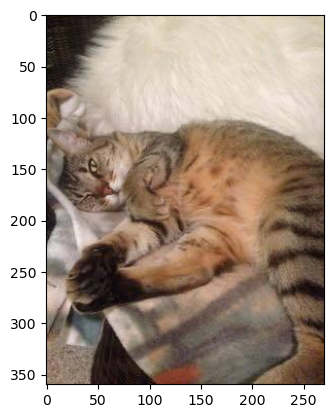

In [6]:
sample_img = cv2.imread(os.path.join("/kaggle/input/cat-breed-images/actually_used_data", "bengal_cat", "bengal_cat1098.jpg"))
plt.imshow(cv2.cvtColor(sample_img, cv2.COLOR_BGR2RGB)) # openCV reads as BGR and not RGB

## Loading the dataset

In [7]:
# tf.keras.utils.image_dataset_from_directory??

In [8]:
data = tf.keras.utils.image_dataset_from_directory("/kaggle/input/cat-breed-images/actually_used_data",
                                                   batch_size=32,
                                                   class_names=class_list
                                                   )
# builds the dataset by labeling the images, resizing the images and even batching the images

Found 4558 files belonging to 4 classes.


In [9]:
data_iterator = data.as_numpy_iterator()
batch = data_iterator.next()
print(batch[0].shape, batch[1].shape)

(32, 256, 256, 3) (32,)


In [10]:
batch[1]
# 0 - bengal
# 1 - bombay
# 2 - himalayan
# 3 - persian

array([0, 2, 3, 0, 2, 2, 2, 1, 3, 3, 0, 1, 2, 2, 1, 0, 3, 1, 0, 2, 1, 1,
       2, 2, 2, 1, 1, 2, 1, 2, 2, 3], dtype=int32)

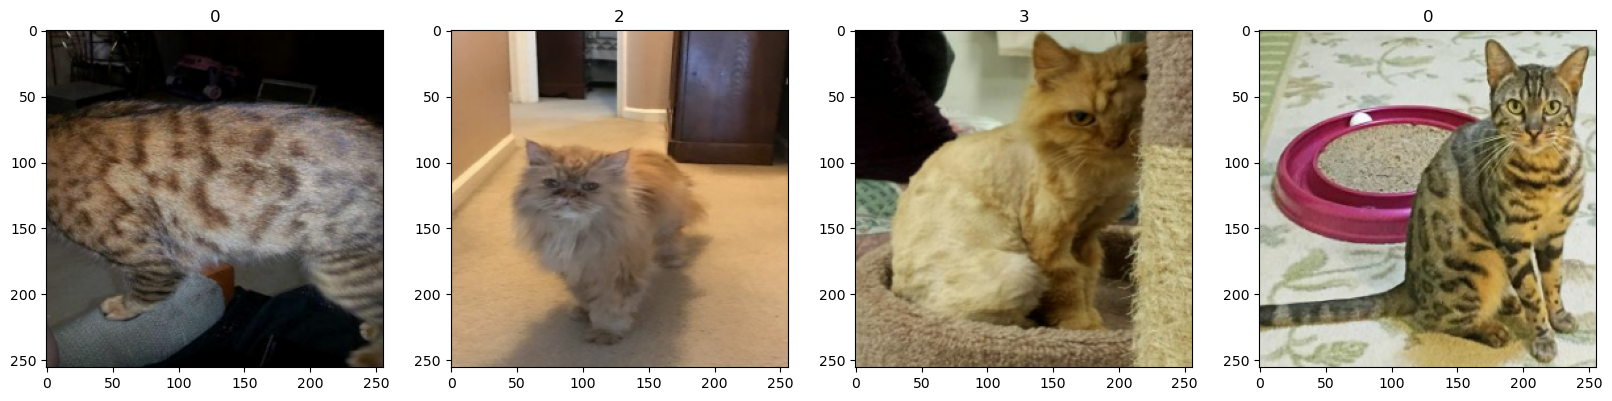

In [11]:
# know the current batch
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]): # 1st 4 images of current batch
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

plt.show()

## Data Augmentation

In [12]:
import albumentations as album

In [13]:
augmentor = album.Compose([ # augmented image size
                         album.HorizontalFlip(p=0.5), 
                         album.RandomBrightnessContrast(p=0.4),
                         album.RandomGamma(p=0.3), 
                         album.RGBShift(p=0.2), 
                         album.VerticalFlip(p=0.5)])

In [14]:
sample_image = cv2.imread("/kaggle/input/cat-breed-images/actually_used_data/himalayan_cat/1.jpg")
augmented = augmentor(image=sample_image)
# plt.imshow(cv2.cvtColor(augmented['image'], cv2.COLOR_BGR2RGB))
# augmented

In [17]:
os.mkdir('/kaggle/working/aug_data/')
for partition in ['bengal_cat','bombay_cat','himalayan_cat','persian_cat']:
    os.mkdir(f"/kaggle/working/aug_data/{partition}/")

In [18]:
for partition in ['bengal_cat','bombay_cat','himalayan_cat','persian_cat']: 
    for image in os.listdir(os.path.join('/kaggle/input/cat-breed-images/actually_used_data', partition)):
        img = cv2.imread(os.path.join('/kaggle/input/cat-breed-images/actually_used_data', partition, image)) # reading image in a partition
        try: 
            for x in range(25): # 25 augmented images for each image passed
                augmented = augmentor(image=img)
                cv2.imwrite(os.path.join('/kaggle/working/aug_data/', partition, f'{image.split(".")[0]}.{x}.jpg'), augmented['image'])

        except Exception as e:
            print(e) # print the error, rather than just stopping the cell execution

In [19]:
final_data = tf.keras.utils.image_dataset_from_directory("/kaggle/working/aug_data",
                                                   batch_size=32,
                                                   class_names=class_list
                                                   )

Found 113950 files belonging to 4 classes.


So we were able to increase the dataset size by **25 times**.

## Preprocess the data

In [20]:
# scale the data
final_data = final_data.map(lambda x, y: (x/255.0, y)) # x=pixel values and y=label

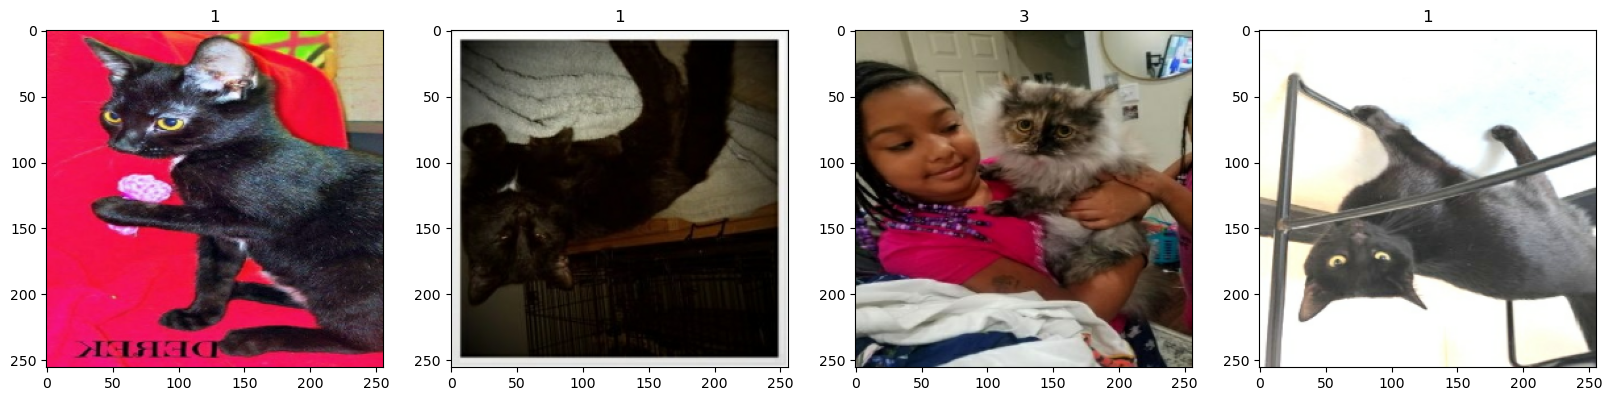

In [21]:
new_batch = final_data.as_numpy_iterator().next()

fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(new_batch[0][:4]): # 1st 4 images of current batch
    ax[idx].imshow(img)
    ax[idx].title.set_text(new_batch[1][idx])

plt.show()

# note that the pixel values values are now between 0. and 1.

## Train-Test-Validation Split

In [22]:
len(final_data) # number of batches

3561

In [23]:
train_size = int(len(final_data)*0.7)
val_size = int(len(final_data)*0.2)
test_size = int(len(final_data)*0.1)+1
print(train_size+val_size+test_size) # = 3561 is a must

3561


In [24]:
# split the data
train = final_data.take(train_size) # tf method to take amount of data
val = final_data.skip(train_size).take(val_size)
test = final_data.skip(train_size+val_size).take(test_size)

In [25]:
len(train), len(val), len(test) # number of batches

(2492, 712, 357)

## Using Keras sequential API for creating the model

In [26]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, GlobalMaxPooling2D, Dropout

In [27]:
model = Sequential()

# Convolution block 1
model.add(Conv2D(filters=32, kernel_size=(5,5), input_shape=(256,256,3)))
model.add(MaxPooling2D())

# Convolution block 2
model.add(Conv2D(filters=64, kernel_size=(3,3), padding="same"))
model.add(MaxPooling2D())

# Convolution block 3
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same"))
model.add(MaxPooling2D())

# Convolution block 4
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same"))
model.add(MaxPooling2D())

# model.add(Flatten())
model.add(GlobalMaxPooling2D())

# fully connected layers
model.add(Dense(512, activation="relu", kernel_initializer="he_normal"))
model.add(Dropout(0.5))
model.add(Dense(512, activation="relu", kernel_initializer="he_normal"))
model.add(Dropout(0.5))

model.add(Dense(4, activation="softmax"))

In [28]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 252, 252, 32)      2432      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 126, 126, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 126, 126, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 63, 63, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 63, 63, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 31, 31, 128)      0

In [29]:
model.compile(
    optimizer='adam',
    loss="sparse_categorical_crossentropy", # multiclass classification
    metrics=["accuracy"]
)

In [30]:
logdir = "/kaggle/working/logs_dir"
# directory where all the model training stages (checkpoints) will be added

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

# best model will be stored, which performed best on validation set
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint("/kaggle/working/model/cat_breed_classifier_insp_best_model.h5",save_best_only=True)

In [31]:
model_history = model.fit(train, epochs=40, validation_data=val, callbacks=[tensorboard_callback, checkpoint_callback])

Epoch 1/40
2492/2492 [==============================] - 401s 156ms/step - loss: 0.9030 - accuracy: 0.6052 - val_loss: 0.7323 - val_accuracy: 0.6820
Epoch 2/40
2492/2492 [==============================] - 367s 147ms/step - loss: 0.4699 - accuracy: 0.8180 - val_loss: 0.4172 - val_accuracy: 0.8481
Epoch 3/40
2492/2492 [==============================] - 320s 128ms/step - loss: 0.3203 - accuracy: 0.8834 - val_loss: 0.3288 - val_accuracy: 0.8672
Epoch 4/40
2492/2492 [==============================] - 372s 149ms/step - loss: 0.2432 - accuracy: 0.9152 - val_loss: 0.1927 - val_accuracy: 0.9320
Epoch 5/40
2492/2492 [==============================] - 371s 148ms/step - loss: 0.2005 - accuracy: 0.9329 - val_loss: 0.1581 - val_accuracy: 0.9491
Epoch 6/40
2492/2492 [==============================] - 323s 130ms/step - loss: 0.1759 - accuracy: 0.9442 - val_loss: 0.2161 - val_accuracy: 0.9297
Epoch 7/40
2492/2492 [==============================] - 374s 150ms/step - loss: 0.1678 - accuracy: 0.9485 - val_

In [32]:
# training further might lead to overfitting on train data

In [33]:
best_model = tf.keras.models.load_model("/kaggle/working/model/cat_breed_classifier_insp_best_model.h5") # rollback to best model

In [34]:
# model.save(os.path.join('/content/drive/MyDrive/datasets/models','cat_breed_classifier_zf_net_insp_15_epoch.h5')) # saving the model

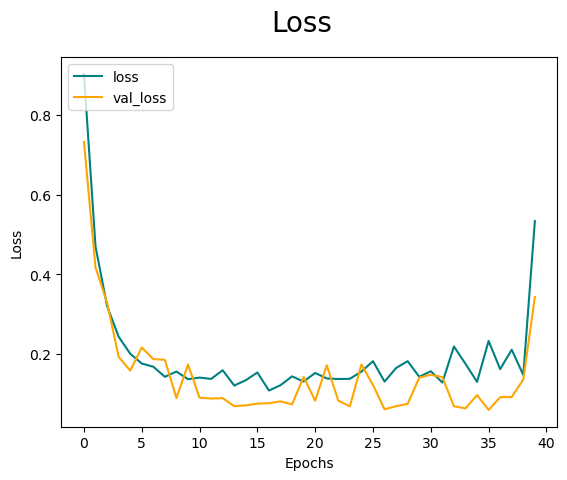

In [35]:
fig = plt.figure()
plt.plot(model_history.history['loss'], color='teal', label='loss')
plt.plot(model_history.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc="upper left")
plt.show()

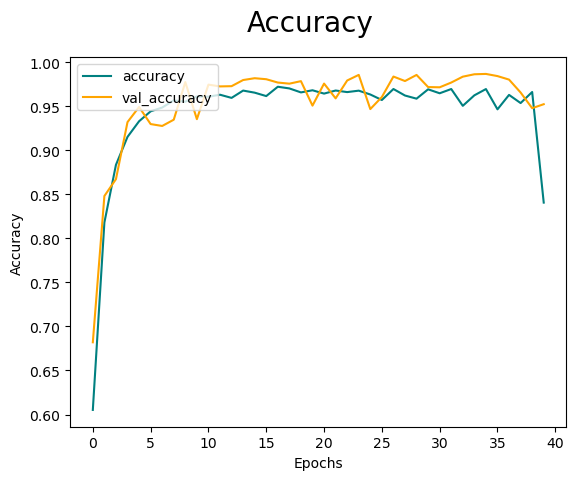

In [36]:
fig = plt.figure()
plt.plot(model_history.history['accuracy'], color='teal', label='accuracy')
plt.plot(model_history.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc="upper left")
plt.show()

## Model evaluation

In [37]:
from tensorflow.keras.metrics import Precision, Recall, Accuracy

In [38]:
pre = Precision()
recall = Recall()
acc = Accuracy()

for batch in test.as_numpy_iterator():
    X, y = batch
    yhat = best_model.predict(X)
    # yhat = tf.nn.softmax(yhat, axis=1) # use when from_logit=True
    # print(yhat)
    yhat = tf.math.argmax(yhat, axis=1)
    pre.update_state(y, yhat)
    recall.update_state(y, yhat)
    acc.update_state(y, yhat)

print(f"Precision is {pre.result()}, Recall is {recall.result()}, Accuracy is {acc.result()}, F1Score is {(2*pre.result()*recall.result())/(pre.result()+recall.result())}")

1/1 [==============================] - 1s 514ms/step
Precision is 0.9966528415679932, Recall is 0.9996526837348938, Accuracy is 0.9857292771339417, F1Score is 0.9981505870819092


## Plotting the model architecture

In [11]:
loaded_model = tf.keras.models.load_model("D:\Coding\ML\Projects\Cat_Breed_Prediction\model\cat_breed_classifier_insp_best_model.h5")

In [17]:
tf.keras.utils.plot_model(
    loaded_model,
    to_file='own-model.png',
)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


## Testing on new image

In [39]:
# test_img = cv2.imread("/content/HD-wallpaper-persian-cat-cat-kitten-little.jpg")
# plt.imshow(cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB))
# plt.show()

In [40]:
# resize_test = tf.image.resize(test_img, (256,256))
# plt.imshow(resize_test.numpy().astype(int))
# plt.show()

In [41]:
# resize_test.shape, np.expand_dims(resize_test/255.0, 0).shape

In [42]:
# yhat = tf.math.argmax(custom_model.predict(np.expand_dims(resize_test/255.0, 0)), axis=1) # keras expects data as batches

In [43]:
# yhat

In [44]:
# print("predicted breed is",class_list[yhat[0]])